In [1]:
import json
import random
from glob import glob
from itertools import chain

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# EDA General

In [113]:
random.seed(42)
image_sizes = set()
for img_path in tqdm(random.sample(glob('./data/train/**/*.*', recursive=True), k=1_000)):
    img = cv.imread(img_path)
    image_sizes.add(img.shape[0] * img.shape[1])
len(image_sizes)

  0%|          | 0/1000 [00:00<?, ?it/s]

1

evidence: likely all images have the same size

In [2]:
df = pd.read_csv('./data/train_ship_segmentations_v2.csv')
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [3]:
df['EncodedPixels'] = df['EncodedPixels'].map(lambda it: [int(n) for n in it.split()] if not pd.isna(it) else np.nan)
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,"[264661, 17, 265429, 33, 266197, 33, 266965, 3..."
3,000194a2d.jpg,"[360486, 1, 361252, 4, 362019, 5, 362785, 8, 3..."
4,000194a2d.jpg,"[51834, 9, 52602, 9, 53370, 9, 54138, 9, 54906..."


In [4]:
print(f'Image count: {df["ImageId"].nunique()}, entries count: {len(df)}')

Image count: 192556, entries count: 231723


evidence: there are some images with labels described by several entries. Likely it means 1 entry describes 1 ship

In [5]:
df_backgrounds = df[pd.isna(df['EncodedPixels'])].copy()
df_ships = df[~pd.isna(df['EncodedPixels'])].copy()
df_ship_groups = df_ships.groupby(by='ImageId')
print(f'Background image count: {len(df_backgrounds)}. Ship image count: {len(df_ship_groups)}')

Background image count: 150000. Ship image count: 42556


# Detect and handle image intersections

In [66]:
df_ships["EncodedPixelsByMod"] = df_ships.EncodedPixels.apply(
    lambda x: ' '.join(list(map(str, x[1::2]))) + ' ' + ' '.join([str(hor % 256) for hor in x[0::2]]) if (
        isinstance(x, list)) else x)
df_ships.head()

,ImageId,EncodedPixels,EncodedPixelsByMod
2,000155de5.jpg,"[264661, 17, 265429, 33, 266197, 33, 266965, 3...",17 33 33 33 33 33 33 33 33 33 33 33 33 33 33 3...
3,000194a2d.jpg,"[360486, 1, 361252, 4, 362019, 5, 362785, 8, 3...",1 4 5 8 10 10 9 10 10 9 9 10 10 9 9 9 10 9 9 7...
4,000194a2d.jpg,"[51834, 9, 52602, 9, 53370, 9, 54138, 9, 54906...",9 9 9 9 9 7 7 7 7 7 7 7 9 9 9 9 9 9 122 122 12...
5,000194a2d.jpg,"[198320, 10, 199088, 10, 199856, 10, 200624, 1...",10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 1...
6,000194a2d.jpg,"[55683, 1, 56451, 1, 57219, 1, 57987, 1, 58755...",1 1 1 1 1 1 1 131 131 131 131 131 131 131


In [67]:
# Verify that 'EncodedPixelsByMod' values only occurs mainly a few times 
df_ships["EncodedPixelsByMod"].value_counts().describe()

count    18996.000000
mean         4.302116
std          2.610800
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         15.000000
Name: count, dtype: float64

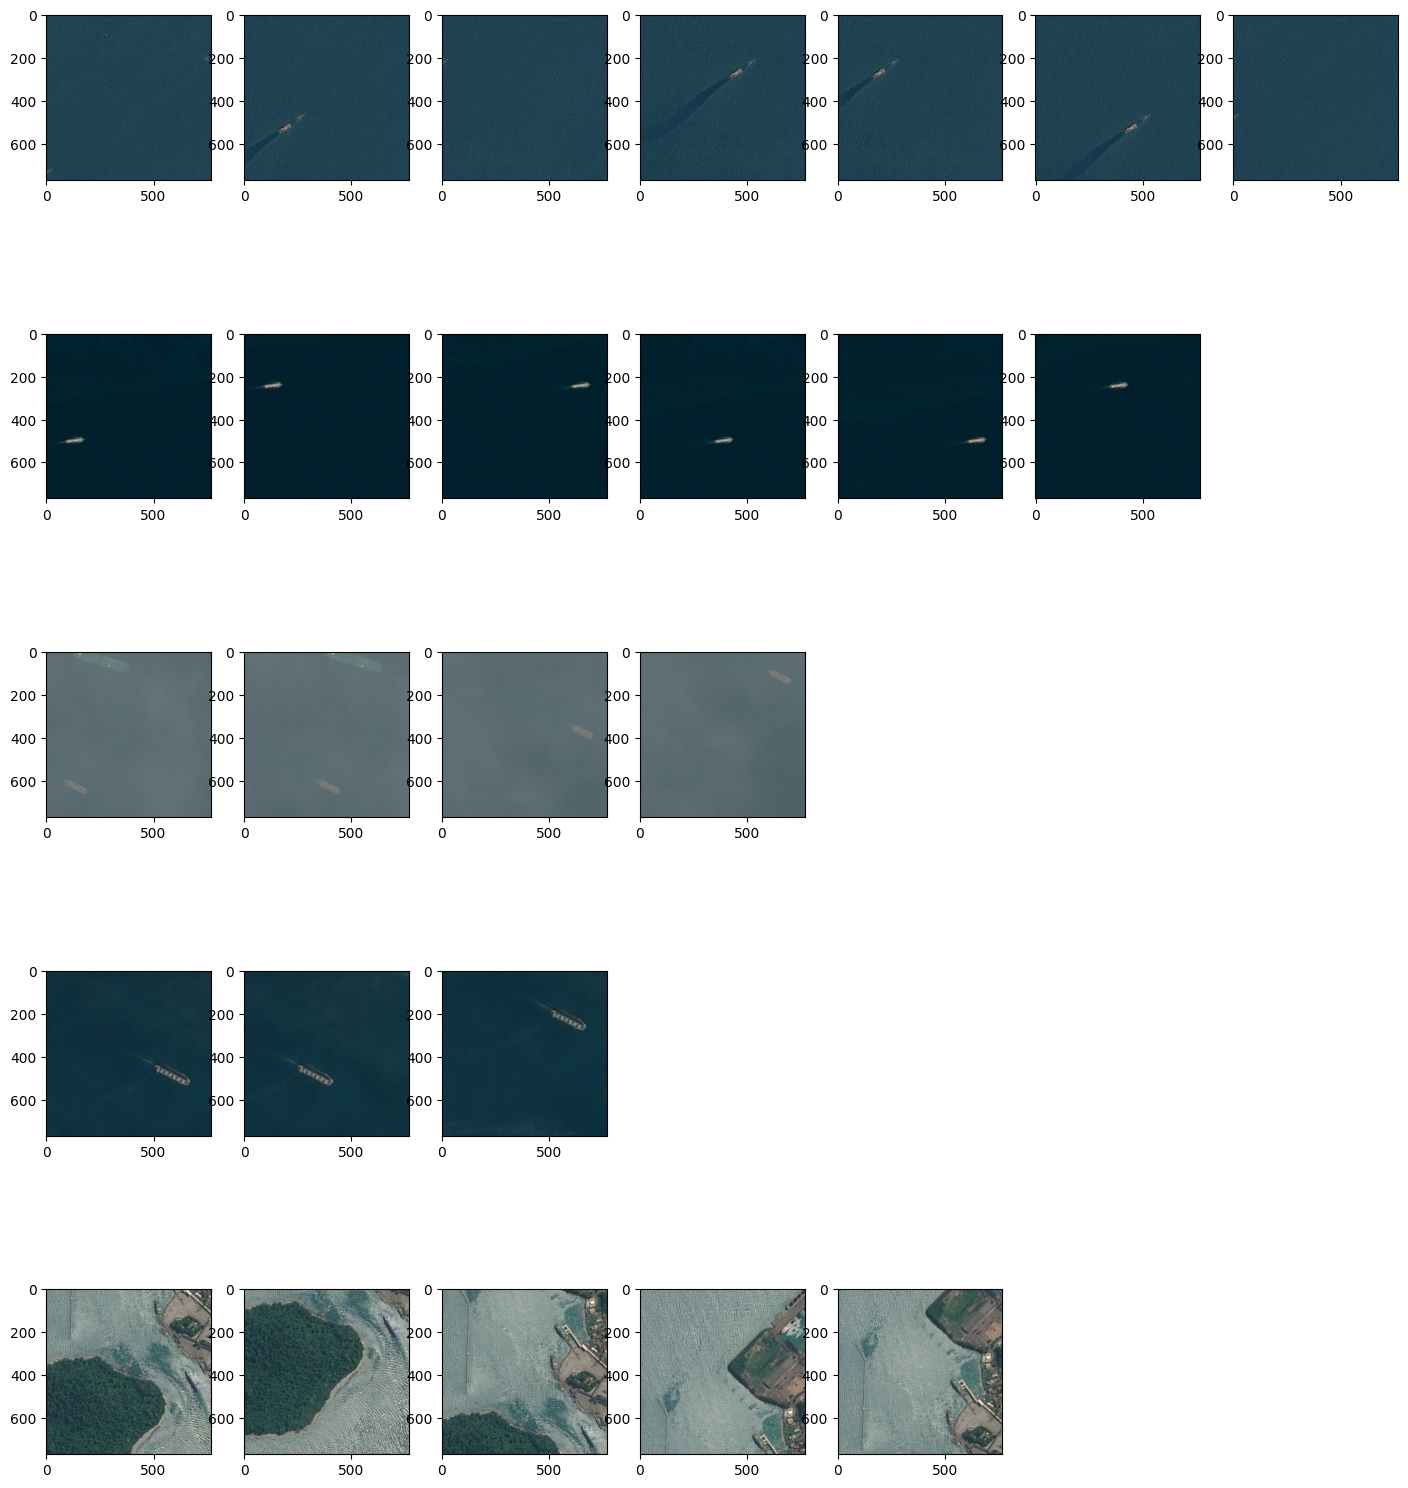

In [80]:
def get_image_data(image_id):
    img_path = glob(f'./data/train/**/{image_id}', recursive=True)[0]
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = img.astype(np.uint8)

    return img

%matplotlib inline

maxRepetition = 8
plt.figure(figsize=(20, 20))
ImgNumber = 5
i = 0
for y in range(ImgNumber):
    image_id = df_ships['ImageId'].tolist()[np.random.randint(0, len(df_ships))]
    id_list = []
    for _, row in df_ships.iloc[df_ship_groups.indices.get(image_id)].iterrows():
        id_list.extend(df_ships[df_ships['EncodedPixelsByMod'] == row['EncodedPixelsByMod']].ImageId)

    id_list = list(set(id_list))
    if len(id_list) > maxRepetition:
        id_list = id_list[:maxRepetition]
    for ID in id_list:
        i += 1
        img = get_image_data(ID)
        plt.subplot(ImgNumber, maxRepetition, i)
        plt.imshow(img, cmap='binary')
    i = maxRepetition * (y + 1)

In [90]:
excluded_image_ids = set()
selected_image_ids = []
for group_id, group_df in tqdm(df_ship_groups):
    if group_id in excluded_image_ids:
        continue
    selected_image_ids.append(group_id)
    group_ship_descriptors = group_df['EncodedPixelsByMod']
image_id_list = df_ships[df_ships['EncodedPixelsByMod'].isin(group_ship_descriptors)]['ImageId']
    image_id_list = [id_ for id_ in image_id_list if id_ != group_id]
    excluded_image_ids = excluded_image_ids.union(image_id_list)

  0%|          | 0/42556 [00:00<?, ?it/s]

In [97]:
df_unique = df_ships[df_ships['ImageId'].isin(selected_image_ids)]
print(len(selected_image_ids), len(df_unique))
df_unique.head()

8635 15912


,ImageId,EncodedPixels,EncodedPixelsByMod
2,000155de5.jpg,"[264661, 17, 265429, 33, 266197, 33, 266965, 3...",17 33 33 33 33 33 33 33 33 33 33 33 33 33 33 3...
3,000194a2d.jpg,"[360486, 1, 361252, 4, 362019, 5, 362785, 8, 3...",1 4 5 8 10 10 9 10 10 9 9 10 10 9 9 9 10 9 9 7...
4,000194a2d.jpg,"[51834, 9, 52602, 9, 53370, 9, 54138, 9, 54906...",9 9 9 9 9 7 7 7 7 7 7 7 9 9 9 9 9 9 122 122 12...
5,000194a2d.jpg,"[198320, 10, 199088, 10, 199856, 10, 200624, 1...",10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 1...
6,000194a2d.jpg,"[55683, 1, 56451, 1, 57219, 1, 57987, 1, 58755...",1 1 1 1 1 1 1 131 131 131 131 131 131 131


In [101]:
df_to_serialize = df_unique[['ImageId', 'EncodedPixels']].copy()
df_to_serialize['EncodedPixels'] = df_to_serialize['EncodedPixels'].map(lambda it: json.dumps(it))
df_to_serialize.head()

,ImageId,EncodedPixels
2,000155de5.jpg,"[264661, 17, 265429, 33, 266197, 33, 266965, 3..."
3,000194a2d.jpg,"[360486, 1, 361252, 4, 362019, 5, 362785, 8, 3..."
4,000194a2d.jpg,"[51834, 9, 52602, 9, 53370, 9, 54138, 9, 54906..."
5,000194a2d.jpg,"[198320, 10, 199088, 10, 199856, 10, 200624, 1..."
6,000194a2d.jpg,"[55683, 1, 56451, 1, 57219, 1, 57987, 1, 58755..."


In [103]:
df_to_serialize.to_csv('./data/train_unique.csv', index=False)

# EDA ships

In [4]:
df_ships = pd.read_csv('../data/train_unique.csv')
df_ships['EncodedPixels'] = df_ships['EncodedPixels'].map(lambda it: json.loads(it))
df_ships.head()

,ImageId,EncodedPixels
0,000155de5.jpg,"[264661, 17, 265429, 33, 266197, 33, 266965, 3..."
1,000194a2d.jpg,"[360486, 1, 361252, 4, 362019, 5, 362785, 8, 3..."
2,000194a2d.jpg,"[51834, 9, 52602, 9, 53370, 9, 54138, 9, 54906..."
3,000194a2d.jpg,"[198320, 10, 199088, 10, 199856, 10, 200624, 1..."
4,000194a2d.jpg,"[55683, 1, 56451, 1, 57219, 1, 57987, 1, 58755..."


In [5]:
df_ship_groups = df_ships.groupby(by='ImageId')

In [6]:
ship_count_per_image = df_ship_groups.count()['EncodedPixels']
print(f'min: {ship_count_per_image.min()}\n' +
      f'max: {ship_count_per_image.max()}\n' +
      f'mean: {round(ship_count_per_image.mean(), 2)}\n' +
      f'median: {ship_count_per_image.median()},\n'
      f'Q 95: {np.quantile(ship_count_per_image, q=0.95)},\n'
      f'Q 99: {np.quantile(ship_count_per_image, q=0.99)},\n')

min: 1
max: 15
mean: 1.84
median: 1.0,
Q 95: 5.0,
Q 99: 11.0,


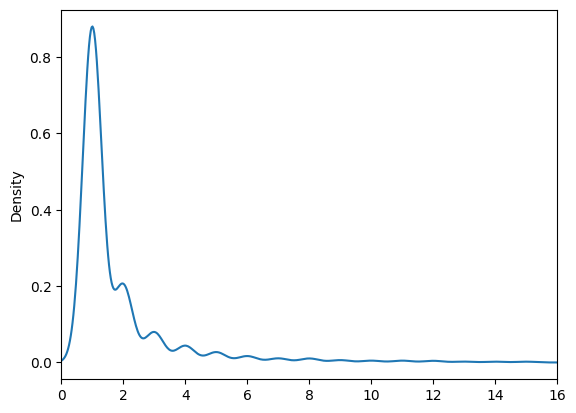

In [111]:
ship_count_per_image.plot(kind='density', xlim=(0, 16))
plt.show()

evidence: most images contains 1 or several ships

In [7]:
ship_size_image_list = []
for _, df_group in tqdm(df_ship_groups):
    ship_size_list = []
    for idx, row in df_group.iterrows():
        ship_size_list.append(
            sum(row['EncodedPixels'][1::2])
        )
    ship_size_image_list.append(np.asarray(ship_size_list))

  0%|          | 0/8635 [00:00<?, ?it/s]

In [8]:
ship_sizes_all = pd.Series(list(chain(*ship_size_image_list)))
print(f'Ship size:\n' +
      f'min: {ship_sizes_all.min()}\n' +
      f'max: {ship_sizes_all.max()}\n' +
      f'mean: {round(ship_sizes_all.mean(), 2)}\n' +
      f'median: {ship_sizes_all.median()},\n'
      f'Q 95: {round(np.quantile(ship_sizes_all, q=0.95))},\n'
      f'Q 99: {round(np.quantile(ship_sizes_all, q=0.99))},\n')

Ship size:
min: 2
max: 25904
mean: 1968.42
median: 531.0,
Q 95: 9546,
Q 99: 15906,


In [27]:
threshold_small_ship = 50
threshold_big_ship = 7500
small_big_ships_count = np.asarray([(ship_size_image > threshold_big_ship).any() and (ship_size_image < threshold_small_ship).any()
            for ship_size_image in ship_size_image_list]).sum()
big_ships_count = np.asarray([(ship_size_image > threshold_big_ship).any() and len(ship_size_image) > 1
            for ship_size_image in ship_size_image_list]).sum()
small_ships_count = np.asarray([(ship_size_image < threshold_small_ship).any()  and len(ship_size_image) > 1
            for ship_size_image in ship_size_image_list]).sum()
print(f'big ships: {big_ships_count}, small ships: {small_ships_count}, small and big ships on the same image: {small_big_ships_count}')

big ships: 341, small ships: 451, small and big ships on the same image: 10


evidence: if there is a very big ship on the image, the probability to have small ship on the same image is small.

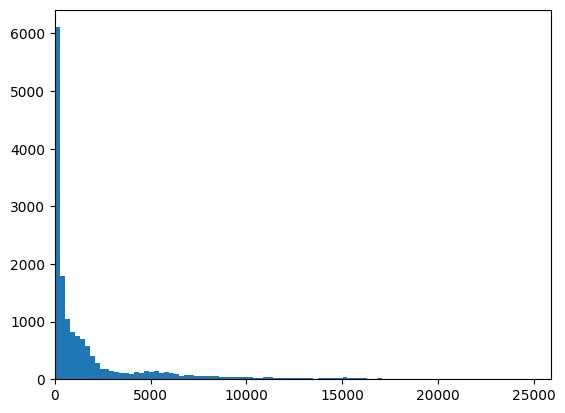

In [156]:
plt.hist(ship_sizes_all, bins = 100)
plt.xlim((0, 25905))
plt.show()

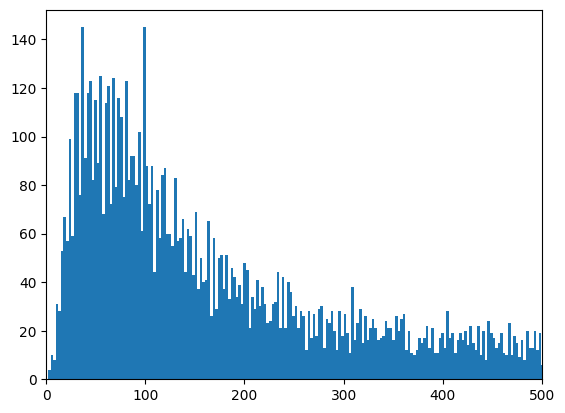

In [161]:
plt.hist(ship_sizes_all, bins=10000)
plt.xlim((0, 500))
plt.show()

evidence: there are more small ships than large. The biggest number of ships belongs to the interval of 25-125px size

In [142]:
image_size = 768 ** 2
print(f'Smallest ship is {round(ship_sizes_all.min() / image_size, 6)}% of image')
print(f'Median ship is {round(ship_sizes_all.median() / image_size, 4)}% of image')
print(f'Largest ship is {round(ship_sizes_all.max() / image_size, 4)}% of image')

Smallest ship is 3e-06% of image
Median ship is 0.0009% of image
Largest ship is 0.0439% of image


In [158]:
image_shape = (768, 768)
ship_on_the_edge_list = []
for idx, row in tqdm(df.iterrows()):
    encoding_run_length = row['EncodedPixels']
    is_ship_on_the_edge = False
    for encoding_idx in range(0, len(encoding_run_length), 2):
        start_idx = encoding_run_length[encoding_idx] - 1
        for add_idx in range(encoding_run_length[encoding_idx + 1]):
            x = (start_idx + add_idx) // image_shape[0]
            y = (start_idx + add_idx) % image_shape[0]
            if x == 0 or y == 0 or x == image_shape[1] - 1 or y == image_shape[0] - 1:
                is_ship_on_the_edge = True
                break
        if is_ship_on_the_edge:
            break
    ship_on_the_edge_list.append(is_ship_on_the_edge)

0it [00:00, ?it/s]

In [160]:
print(f'There are {sum(ship_on_the_edge_list)} ships on the edge of the image')

There are 2016 ships on the edge of the image


consequence: If the ship is on the image edge it means it is partially cut. Therefore, the model should predict properly not only the entire ship, but it parts as well